In [1]:
!pip --quiet install kaggle
!pip --quiet install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.4 MB/s eta 0:00:00


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # This command changes the permission of the file to be read and write by the user only, for security purposes.

!kaggle competitions download -c cs-480-2024-spring
!unzip cs-480-2024-spring.zip > /dev/null

 99% 284M/287M [00:04<00:00, 106MB/s] 
100% 287M/287M [00:04<00:00, 63.3MB/s]


In [3]:
import os

import lightning as L
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [4]:
# Setting the seed
L.seed_everything(20873644)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

if device == torch.device("cuda:0"):
  print('Everything looks good; continue')
else:
  print('GPU is not detected. Make sure you have chosen the right runtime type')


INFO: Seed set to 20873644
INFO:lightning.fabric.utilities.seed:Seed set to 20873644


GPU is not detected. Make sure you have chosen the right runtime type


In [5]:
# Read training and testing csv
train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43363 entries, 0 to 43362
Columns: 170 entries, id to X3112_mean
dtypes: float64(48), int64(122)
memory usage: 56.2 MB


In [10]:
# Define PlantImage dataset class
class PlantImage(Dataset):
    def __init__(self, csv_data, transform=None):
        """
        Args:
            csv_file (dataframe): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.csv_data = csv_data
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        img_num = self.csv_data.iloc[idx, 0]
        img_name = os.path.join("data/train_images", str(img_num) + ".jpeg")
        image = Image.open(img_name).convert('RGB')

        # Get label from column 165 to 170
        labels = self.csv_data.iloc[idx, 164:171].values

        # Reshape to 2D array so that PyTorch can create batches
        labels = labels.astype('float').reshape(1, 6)

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'labels': labels}

        return sample

In [7]:
# Function to calculate mean and standard deviation for images in dataloader
def calculate_mean_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data in dataloader:
        images = data['image']

        # Mean across batch, height, and width, but preserve channels
        channels_sum += torch.mean(images, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(images**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# Calculate mean and standard deviation for training set to apply normalization
base_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

dataloader = DataLoader(PlantImage(train_data, base_transform), batch_size=64, shuffle=True, drop_last=False)

mean, std = calculate_mean_std(dataloader)

print(mean)
print(std)

tensor([0.4464, 0.4505, 0.3360])
tensor([0.2184, 0.2089, 0.2188])


INFO: Seed set to 20873644
INFO:lightning.fabric.utilities.seed:Seed set to 20873644
INFO: Seed set to 20873644
INFO:lightning.fabric.utilities.seed:Seed set to 20873644


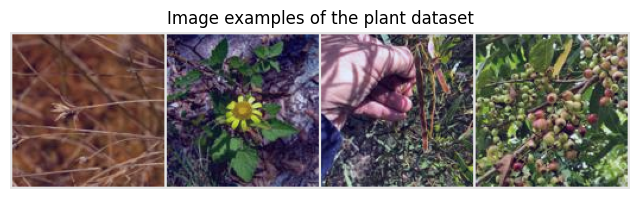

In [12]:
# Transformations applied to training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.5),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomApply([
        transforms.Lambda(lambda x: x + torch.sqrt(torch.tensor(0.01)) * torch.randn_like(x))
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Transformations applied to testing set
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)


# Loading the training dataset. We need to split it into a training and validation part using 80-20 split
train_dataset = PlantImage(train_data, transform=train_transform)
val_dataset = PlantImage(train_data, transform=test_transform)

L.seed_everything(20873644)
train_set, _ = torch.utils.data.random_split(train_dataset, [34690, 8673])
L.seed_everything(20873644)
_, val_set = torch.utils.data.random_split(val_dataset, [34690, 8673])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=1)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=1)


# Loading the test set
test_set = PlantImage(test_data, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=1)


# Display 4 Images
dataiter = iter(val_loader)
batch = next(dataiter)
plant_images = batch['image']

NUM_IMAGES = 4
selected_images = plant_images[:NUM_IMAGES]
img_grid = torchvision.utils.make_grid(selected_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the plant dataset")
plt.imshow(img_grid.numpy())
plt.axis("off")
plt.show()